In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정합니다
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# 데이터셋의 경로
dataroot = "data/celeba"

# dataloader에서 사용할 쓰레드 수
workers = 2

# 배치 크기
batch_size = 128

# 이미지의 크기입니다. 모든 이미지들은 transformer를 이용해 64로 크기가 통일됩니다.
image_size = 64

# 이미지의 채널 수로, RGB 이미지이기 때문에 3으로 설정합니다.
nc = 3

# 잠재공간 벡터의 크기 (예. 생성자의 입력값 크기)
nz = 100

# 생성자를 통과하는 특징 데이터들의 채널 크기
ngf = 64

# 구분자를 통과하는 특징 데이터들의 채널 크기
ndf = 64

# 학습할 에폭 수
num_epochs = 5

# 옵티마이저의 학습률
lr = 0.0002

# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.5

# 사용가능한 gpu 번호. CPU를 사용해야 하는경우 0으로 설정하세요
ngpu = 1

cuda:0 is available!


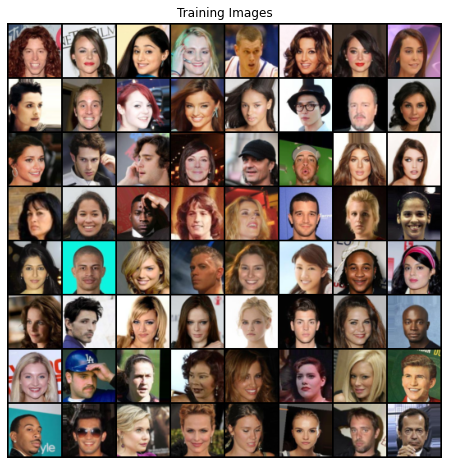

In [9]:
# 우리가 설정한 대로 이미지 데이터셋을 불러와 봅시다
# 먼저 데이터셋을 만듭니다
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# dataloader를 정의해봅시다
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# GPU 사용여부를 결정해 줍니다
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device,"is available!")

# 학습 데이터들 중 몇가지 이미지들을 화면에 띄워봅시다
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
# netG와 netD에 적용시킬 커스텀 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)